In [1]:
!curl http://malnet.cc.gatech.edu/image-data/malnet-images-tiny.tar.gz -o malnet-images-tiny.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5372M  100 5372M    0     0  33.1M      0  0:02:42  0:02:42 --:--:-- 34.6M


In [2]:
!tar -xvzf malnet-images-tiny.tar.gz

Streaming output truncated to the last 5000 lines.
malnet-images-tiny/val/backdoor/golddream/27DF766A3C340EC1BB0FBE1807180797665494B6B1700CC2F7967D892E88080A.png
malnet-images-tiny/val/backdoor/golddream/6FCE94CE1AC943852622473BDCBF400CD77EF291376C00185E908BB3181084BD.png
malnet-images-tiny/val/backdoor/golddream/2972E4EAE8C48250A73C986281BA4AE1ED17251FBC940BE9FFC9A74251E2009A.png
malnet-images-tiny/val/backdoor/golddream/BAB021F39BE0C636105644C78F85FC1530519AF99E152C49E8BC3E912C04E2A8.png
malnet-images-tiny/val/backdoor/kuguo/
malnet-images-tiny/val/backdoor/kuguo/6A823D1A3EF45E384F96EE72AE4BBDF3AED0EEC8B6C111EE3997D4EC88548863.png
malnet-images-tiny/val/backdoor/kuguo/2C843A60D15235968FF4801E2612E831773CB58E1EB61A1D5BBF85B30E5AEE09.png
malnet-images-tiny/val/backdoor/kuguo/437BC42F925F5213D7D2FE6C307E99EC7CEFB43B305472B1A67CB0D7DAAE9292.png
malnet-images-tiny/val/backdoor/kuguo/1490A62B7B02E932CDB8F4BA68A37FCB4291A87474ADB34B7C176FE7D43DF166.png
malnet-images-tiny/val/backdoor/kuguo/

In [24]:
import os
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

In [4]:
data_src_dir = "/malnet-images-tiny/"
train_dir = "train/"
test_dir = "test/"
val_dir = "val/"
cwd = os.getcwd().replace('\\', '/')

In [5]:
root_directory = Path(cwd+data_src_dir+train_dir)
folders = []
for f in root_directory.glob("**"):
   folders.append(str(f))

In [6]:
train_types = []
for i in folders:
  tmp = i.replace('\\', '/').replace(cwd+data_src_dir+train_dir, '')
  if len(tmp.split('/')) == 2:
    train_types.append(tmp)
train_types

['downloader/jiagu',
 'downloader/genpua',
 'downloader/tencentprotect',
 'downloader/openconnection',
 'downloader/dowgin',
 'downloader/artemis',
 'downloader/hiddenapps',
 'clicker/jiagu',
 'clicker/delayload',
 'clicker/eldorado',
 'clicker/kuguo',
 'clicker/dowgin',
 'fakeapp/deng',
 'fakeapp/dowgin',
 'fakeapp/artemis',
 'fakeapp/genbl',
 'fakeapp/fakeflash',
 'clicker++trojan/ganlet',
 'clicker++trojan/kuguo',
 'clicker++trojan/dowgin',
 'adsware/mobclixads',
 'adsware/millennialmediaads',
 'adsware/revmobads',
 'adsware/ads',
 'adsware/greystripeads',
 'adsware/charboostads',
 'adsware/tapjoyads',
 'adsware/burstlyads',
 'adsware/jumptapiads',
 'adsware/inmobiads',
 'adsware/leadbolt',
 'adsware/admobads',
 'adsware/adwhirlads',
 'adsware/madhouseads',
 'adsware/genbl',
 'adsware/caulyads',
 'backdoor/kuguo',
 'backdoor/golddream',
 'backdoor/kungfu',
 'backdoor/droidkungfu',
 'backdoor/deng',
 'backdoor/wabot',
 'backdoor/aqin',
 'backdoor/hupigon',
 'backdoor/ginmaster',
 'ba

In [7]:
interested_lables = ['addisplay/airpush', 'adware++virus/kuguo', 'downloader/jiagu', 'troj/artemis', 'smssend/koomer']
label_mapping = {}
for idx, i in enumerate(interested_lables):
  label_mapping[idx] = i
# for idx, i in enumerate(train_types):
#     label_mapping[idx] = i

In [8]:
label_mapping

{0: 'addisplay/airpush',
 1: 'adware++virus/kuguo',
 2: 'downloader/jiagu',
 3: 'troj/artemis',
 4: 'smssend/koomer'}

In [9]:
for i in interested_lables:
  tmps = len(os.listdir(cwd+data_src_dir+train_dir+i))
  print(f'training data files present for label {i} = {tmps}')

training data files present for label addisplay/airpush = 56
training data files present for label adware++virus/kuguo = 9
training data files present for label downloader/jiagu = 1538
training data files present for label troj/artemis = 303
training data files present for label smssend/koomer = 13


In [10]:
for i in interested_lables:
  tmps = len(os.listdir(cwd+data_src_dir+test_dir+i))
  print(f'testing data files present for label {i} = {tmps}')

testing data files present for label addisplay/airpush = 21
testing data files present for label adware++virus/kuguo = 4
testing data files present for label downloader/jiagu = 421
testing data files present for label troj/artemis = 87
testing data files present for label smssend/koomer = 6


In [11]:


class ImageDataset(Dataset):
    def __init__(self, image_dir, label_map, patch_size=16):

        self.image_dir = image_dir
        self.label_map = label_map
        self.patch_size = patch_size
        self.image_paths = []
        self.labels = []

        for index, folder in self.label_map.items():
            folder_path = os.path.join(image_dir, folder)
            if os.path.exists(folder_path):
                print(folder)
                image_files = [f for f in os.listdir(folder_path) if f.endswith(('png'))]
                for img_file in image_files:
                    self.image_paths.append(os.path.join(folder_path, img_file))
                    label = torch.zeros(len(self.label_map))
                    label[index] = 1
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        patches = self.image_to_patches(image)
        return patches, label

    def image_to_patches(self, image):
        img_array = np.array(image)
        patch_size = self.patch_size
        h, w, c = img_array.shape
        patches = []

        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                patch = img_array[i:i+patch_size, j:j+patch_size]
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    patch = patch.flatten()
                    patches.append(patch)

        patches = torch.tensor(np.array(patches), dtype=torch.float32)
        return patches


In [12]:


class EOTransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=4, hidden_dim=16, dropout=0.1, max_len=256, device='cpu'):
        super(EOTransformerModel, self).__init__()

        self.input_dim = input_dim
        self.num_classes = num_classes
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, input_dim))
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer, num_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, num_classes)
        self.device = device
        self.to(self.device)

    def forward(self, x):
        self.positional_encoding = self.positional_encoding.to(x.device)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)

        return F.softmax(x, dim=1)





class FullTransformerModel(nn.Module):

    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=4, hidden_dim=16, dropout=0.1, max_len=256):
        super(FullTransformerModel, self).__init__()

        self.input_dim = input_dim
        self.num_classes = num_classes
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, input_dim))
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer, num_layers=num_layers
        )
        self.transformer_decoder_layer = nn.TransformerDecoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(
            self.transformer_decoder_layer, num_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, num_classes)
        self.device = device
        self.to(self.device)


    def forward(self, src, tgt):

        self.positional_encoding = self.positional_encoding.to(src.device)
        src = src + self.positional_encoding[:, :src.size(1), :]
        memory = self.transformer_encoder(src)
        tgt = tgt + self.positional_encoding[:, :tgt.size(1), :]
        decoded_output = self.transformer_decoder(tgt, memory)
        output = decoded_output.mean(dim=1)
        logits = self.fc(output)
        return F.softmax(logits, dim=1)


def train_model(model, dataloader, optimizer, num_epochs, device):
    history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, one_hot_indices = torch.max(outputs, dim=1)
            one_hot_labels = torch.zeros(outputs.size(0), num_classes, device=device)
            preds = one_hot_labels.scatter(1, one_hot_indices.unsqueeze(1), 1)
            correct_predictions += (preds == labels).sum()

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = (correct_predictions / len(dataloader.dataset)) / num_classes

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return history

def ft_train_model(model, dataloader, optimizer, num_epochs, device):
    history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, one_hot_indices = torch.max(outputs, dim=1)
            one_hot_labels = torch.zeros(outputs.size(0), num_classes,  device=device)
            preds = one_hot_labels.scatter(1, one_hot_indices.unsqueeze(1), 1)
            correct_predictions += (preds == labels).sum()

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = (correct_predictions / len(dataloader.dataset)) / num_classes
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return history


def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)
    loss = torch.tensor(history['loss'], device='cpu').numpy()
    accuracy = torch.tensor(history['accuracy'], device='cpu').numpy()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'ro-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def eo_c_train_model(model, dataloader, optimizer, num_epochs, device):
    history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, one_hot_indices = torch.max(outputs, dim=1)
            one_hot_labels = torch.zeros(outputs.size(0), num_classes, device=device)
            preds = one_hot_labels.scatter(1, one_hot_indices.unsqueeze(1), 1)
            correct_predictions += (preds == labels).sum()

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = (correct_predictions / len(dataloader.dataset)) / num_classes

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return history

In [14]:


# Hyperparameters
batch_size = 32
learning_rate = 1e-4
num_epochs = 5
num_classes = len(label_mapping)

dataset = ImageDataset(image_dir=cwd+data_src_dir+train_dir, label_map=label_mapping, patch_size=16)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 16 * 16 * 3



addisplay/airpush
adware++virus/kuguo
downloader/jiagu
troj/artemis
smssend/koomer


In [15]:
eomodel = EOTransformerModel(input_dim=input_dim, num_classes=num_classes, device=device)
optimizer = Adam(eomodel.parameters(), lr=learning_rate)
history = train_model(eomodel, dataloader, optimizer, num_epochs, device=device)

Epoch [1/5], Loss: 1.1004, Accuracy: 0.9252
Epoch [2/5], Loss: 1.0864, Accuracy: 0.9262
Epoch [3/5], Loss: 1.0695, Accuracy: 0.9318
Epoch [4/5], Loss: 1.0510, Accuracy: 0.9306
Epoch [5/5], Loss: 0.9445, Accuracy: 0.9833


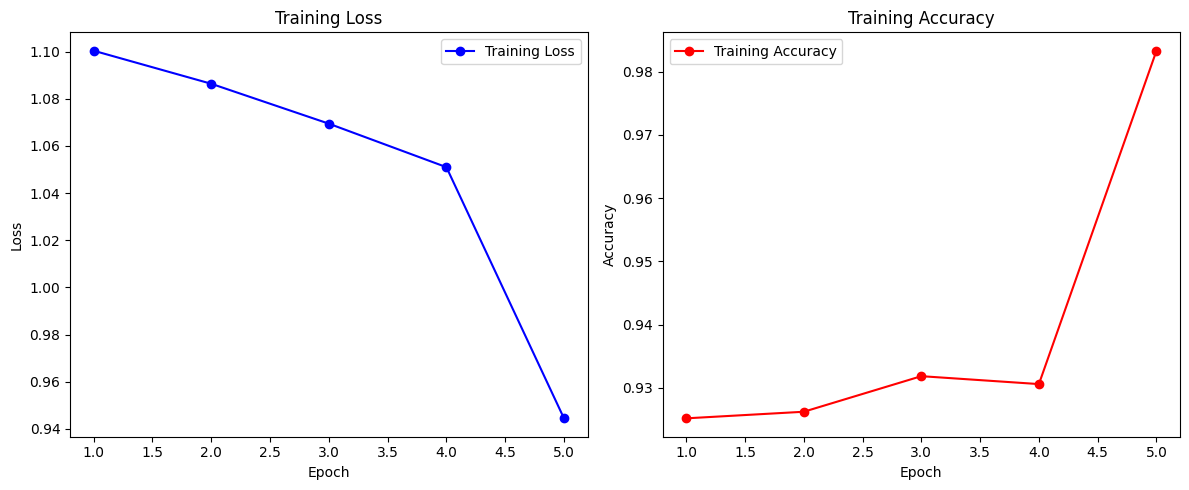

In [16]:

plot_training_history(history)


In [17]:


def evaluate_model_with_patching(model, dataloader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for patches, labels in dataloader:
            patches = patches.to(device)
            labels = labels.to(device)
            outputs = model(patches)
            if outputs.dim() == 3:
                outputs_mean = outputs.mean(dim=1)
            else:
                outputs_mean = outputs

            probs = torch.softmax(outputs_mean, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute metrics
    accuracy = (all_preds == all_labels).mean()
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    # Compute ROC-AUC (one-vs-rest for multi-class)
    roc_auc_macro = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    roc_auc_per_class = roc_auc_score(all_labels, all_probs, multi_class='ovr', average=None)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"ROC-AUC (Macro): {roc_auc_macro:.4f}")
    print("\nMetrics per class:")
    for i, (prec, rec, f1, auc) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class, roc_auc_per_class)):
        print(f"Class {i}: Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {auc:.4f}")

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "roc_auc_macro": roc_auc_macro,
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "f1_per_class": f1_per_class,
        "roc_auc_per_class": roc_auc_per_class,
        "all_preds": all_preds,
        "all_labels": all_labels,
        "all_probs": all_probs,
    }


addisplay/airpush
adware++virus/kuguo
downloader/jiagu
troj/artemis
smssend/koomer


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9425
Precision (Macro): 0.3475
Recall (Macro): 0.4000
F1 Score (Macro): 0.3698
ROC-AUC (Macro): 0.9297

Metrics per class:
Class 0: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC-AUC: 0.9404
Class 1: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC-AUC: 0.8479
Class 2: Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, ROC-AUC: 1.0000
Class 3: Precision: 0.7373, Recall: 1.0000, F1 Score: 0.8488, ROC-AUC: 0.9697
Class 4: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC-AUC: 0.8907


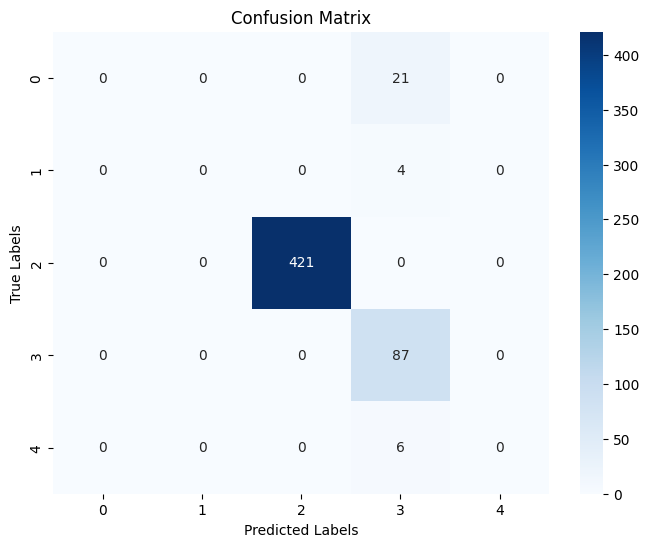

In [20]:

test_dataset = ImageDataset(image_dir=cwd+data_src_dir+test_dir, label_map=label_mapping, patch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
eometrics = evaluate_model_with_patching(eomodel, test_dataloader)

In [ ]:
# torch.save(eomodel.state_dict(), '/content/drive/MyDrive/OMSCS/ML/GP/models/eomodel.pth')

In [ ]:
# del eomodel

In [ ]:
# import gc
# gc.collect()

In [21]:
# Parameters
batch_size = 32
learning_rate = 1e-4
num_epochs = 5
num_classes = len(label_mapping)
patch_size = 16

# dataset = ImageDataset(image_dir=cwd + data_src_dir + train_dir, label_map=label_mapping, patch_size=patch_size)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = patch_size * patch_size * 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ftmodel = FullTransformerModel(input_dim=input_dim, num_classes=num_classes).to(device)
optimizer = Adam(ftmodel.parameters(), lr=learning_rate)




In [27]:
fthistory = ft_train_model(ftmodel, dataloader, optimizer, num_epochs, device=device)


Epoch [1/5], Loss: 0.9826, Accuracy: 0.9689
Epoch [2/5], Loss: 0.9473, Accuracy: 0.9831
Epoch [3/5], Loss: 0.9467, Accuracy: 0.9833
Epoch [4/5], Loss: 0.9467, Accuracy: 0.9833
Epoch [5/5], Loss: 0.9467, Accuracy: 0.9833


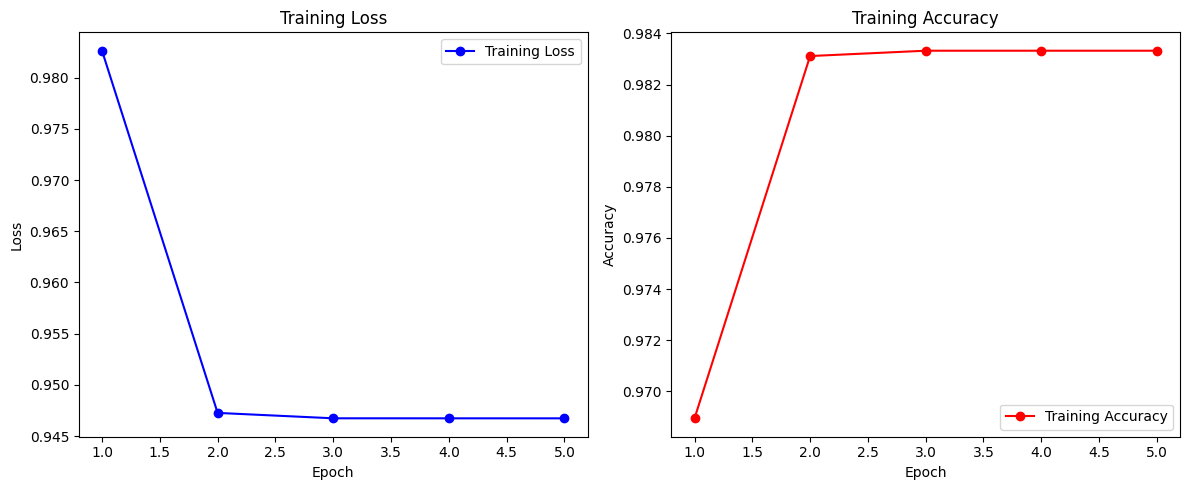

In [28]:
# Plot training history
plot_training_history(fthistory)

In [29]:

def evaluate_model_with_patching_full_transformer(model, dataloader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    all_preds = []
    all_labels = []
    all_probs = []  # To store probabilities for ROC-AUC

    with torch.no_grad():
        for src_patches, labels in dataloader:
            src_patches = src_patches.to(device)
            labels = labels.to(device)
            outputs = model(src_patches, src_patches)

            if outputs.dim() == 3:
                outputs_mean = outputs.mean(dim=1)
            else:
                outputs_mean = outputs

            probs = torch.softmax(outputs_mean, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs.cpu().numpy())  # Save probabilities
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute metrics
    accuracy = (all_preds == all_labels).mean()
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    # Compute ROC-AUC (one-vs-rest for multi-class)
    roc_auc_macro = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    roc_auc_per_class = roc_auc_score(all_labels, all_probs, multi_class='ovr', average=None)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"ROC-AUC (Macro): {roc_auc_macro:.4f}")
    print("\nMetrics per class:")
    for i, (prec, rec, f1, auc) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class, roc_auc_per_class)):
        print(f"Class {i}: Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {auc:.4f}")

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "roc_auc_macro": roc_auc_macro,
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "f1_per_class": f1_per_class,
        "roc_auc_per_class": roc_auc_per_class,
        "all_preds": all_preds,
        "all_labels": all_labels,
        "all_probs": all_probs,
    }


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9425
Precision (Macro): 0.3475
Recall (Macro): 0.4000
F1 Score (Macro): 0.3698
ROC-AUC (Macro): 0.4444

Metrics per class:
Class 0: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC-AUC: 0.1290
Class 1: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC-AUC: 0.0000
Class 2: Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, ROC-AUC: 1.0000
Class 3: Precision: 0.7373, Recall: 1.0000, F1 Score: 0.8488, ROC-AUC: 0.9696
Class 4: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC-AUC: 0.1232


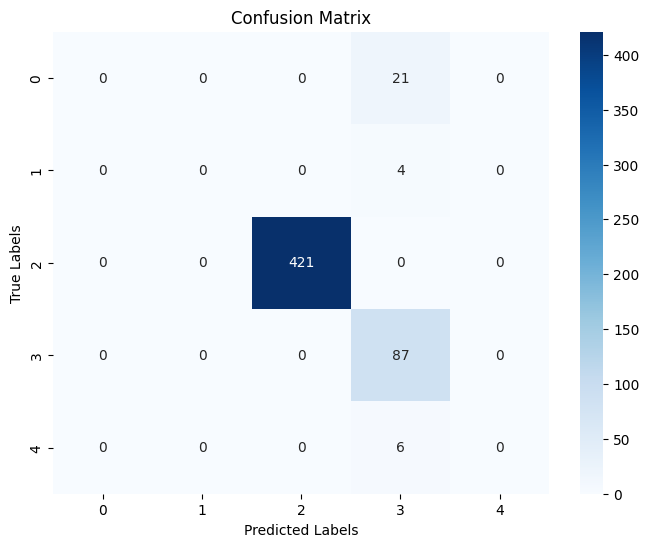

{'accuracy': 0.9424860853432282,
 'precision_macro': 0.3474576271186441,
 'recall_macro': 0.4,
 'f1_macro': 0.3697560975609756,
 'roc_auc_macro': 0.4443654987613833,
 'precision_per_class': array([0.        , 0.        , 1.        , 0.73728814, 0.        ]),
 'recall_per_class': array([0., 0., 1., 1., 0.]),
 'f1_per_class': array([0.        , 0.        , 1.        , 0.84878049, 0.        ]),
 'roc_auc_per_class': array([0.12897591, 0.        , 1.        , 0.96964958, 0.123202  ]),
 'all_preds': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [30]:
ftmetrics = evaluate_model_with_patching_full_transformer(ftmodel, test_dataloader)
ftmetrics

In [ ]:
# torch.save(ftmodel.state_dict(), '/content/drive/MyDrive/OMSCS/ML/GP/models/ftmodel.pth')